In [3]:
import numpy as np
import torch
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

import reservoir
import reckernel
import kuramoto
%load_ext autoreload
%autoreload 2

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
today = '200610'

# Stability analysis

In this notebook, we would like to study the stability of Reservoir Computing and Recurrent Kernel. This fundamental property is important to efficiently implement Recurrent Kernels.

The Echo-State Property in Reservoir Computing states that two different reservoirs with the same inputs and weights but different initializations should converge to the same trajectory after a finite time $\tau$. This is important to ensure that the output in Reservoir Computing does not depend on the initial reservoir state. Without it, results would be inconsistent as they depend on the initialization that may be random. 

The same property is also important to obtain consistent results with Recurrent Kernels. Moreover, Recurrent Kernels need to be iterated for each pairs of inputs a certain number of times. As we only consider the final state of the kernel matrix, this number of iterations can be reduced to this finite memory $\tau$ and not on the full length of the time series. This change reduces considerably the computational costs.

In [4]:
# Generation of Kuramoto data

L = 22 / (2 * np.pi)  # length
N = 100  # space discretization step
dt = 0.25  # time discretization step
N_train = 10000
N_test = 10000
N_init = 1000  # remove the initial points
tend = (N_train + N_test) * dt + N_init

dns = kuramoto.KS(L=L, N=N, dt=dt, tend=tend)
dns.simulate()
u = dns.uu[N_init:] / np.sqrt(N)
[u_train, u_test, _] = np.split(u, [N_train, N_train+N_test], axis=0)

# Stability for Reservoir Computing

We compute the mean-square distance between states of two randomly-initialized reservoirs. They have the same weights and are driven by the same inputs, and this distance should converge to 0 after a finite time if the Echo-State Property is valid.

Depending on the scale of the reservoir and input weights, we observe stable or chaotic dynamics. Basically, if scale_res < 1, the ESP is valid and reservoir dynamics are stable. If scale_re > 1, reservoir dynamics are in general unstable but they may be regularized by an important input_scale.

In [35]:
res_scale = 0.7  # variance of reservoir
input_scale = 0.1  # variance of input

input_data = torch.from_numpy(u_train).to(device)
input_len = 100
input_data = input_data[:input_len, :]
n_input = 1 # number of time series
input_len, input_dim = input_data.shape # time steps t
n_res = 1000

# First reservoir with random initialization
torch.manual_seed(1)
initial_state1 = torch.randn(n_res).to(device) / np.sqrt(n_res)
model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, f='erf')
X1 = model.forward(input_data, initial_state=initial_state1).to(device)

# Second reservoir with random initialization
torch.manual_seed(2)
initial_state2 = torch.randn(n_res).to(device) / np.sqrt(n_res)
model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, f='erf')
X2 = model.forward(input_data, initial_state=initial_state2).to(device)

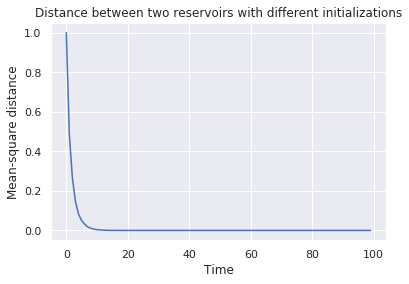

In [36]:
diff2 = torch.mean(torch.abs(X2 - X1)**2, axis=1).cpu()
plt.plot(diff2 / diff2[0])
plt.title('Distance between two reservoirs with different initializations')
plt.xlabel('Time')
plt.ylabel('Mean-square distance');

In [37]:
# Don't forget to change the file name
np.save('out/' + today + '_stability_rc_res' + str(res_scale), 
        diff2)

# Stability for Recurrent Kernels

We repeat the same analysis for Recurrent Kernels. This time, it is performed directly in the test_stability() function of the RecKernel class.

In [44]:
input_data = torch.from_numpy(u_train).to(device)
input_len = 150
input_data = input_data[:input_len, :]

n_input = 1 # number of time series
input_len, input_dim = input_data.shape # time steps t
input_scale = 0.1  # variance of input
res_scale = 0.7  # variance of reservoir

model = reckernel.RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, n_iter=50)
dist2 = model.test_stability(input_data).cpu()

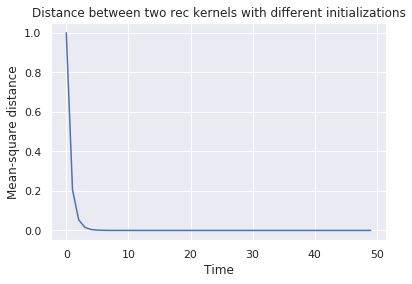

In [45]:
plt.plot(dist2/dist2[0])
plt.title('Distance between two rec kernels with different initializations')
plt.xlabel('Time')
plt.ylabel('Mean-square distance');

In [46]:
# Don't forget to change the file name
np.save('out/' + today + '_stability_rk_res' + str(res_scale), 
        dist2)

# Plots

In [48]:
rc07 = np.load('out/200610_stability_rc_res0.7.npy')
rc1 = np.load('out/200610_stability_rc_res1.npy')
rc15 = np.load('out/200610_stability_rc_res1.5.npy')
rk07 = np.load('out/200610_stability_rk_res0.7.npy')
rk1 = np.load('out/200610_stability_rk_res1.npy')
rk15 = np.load('out/200610_stability_rk_res1.5.npy')

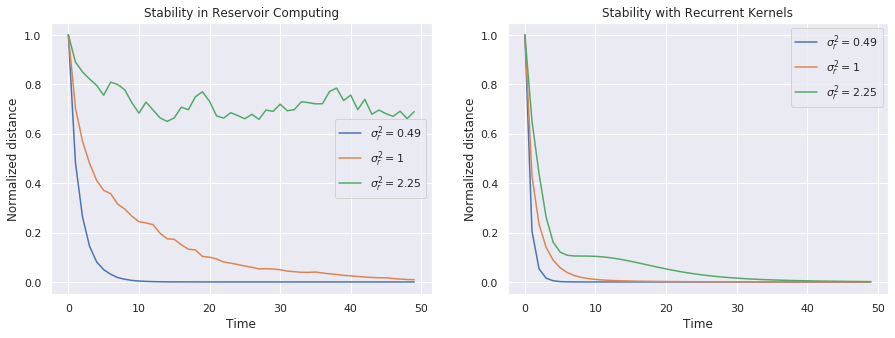

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

axes[0].plot(rc07[:50]/rc07[0])
axes[0].plot(rc1[:50]/rc1[0])
axes[0].plot(rc15[:50]/rc15[0])
axes[0].legend(['$\sigma_r^2=0.49$', '$\sigma_r^2=1$', '$\sigma_r^2=2.25$'])
axes[0].set_title('Stability in Reservoir Computing')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Normalized distance')

axes[1].plot(rk07/rk07[0])
axes[1].plot(rk1/rk1[0])
axes[1].plot(rk15/rk15[0])
axes[1].legend(['$\sigma_r^2=0.49$', '$\sigma_r^2=1$', '$\sigma_r^2=2.25$'])
axes[1].set_title('Stability with Recurrent Kernels')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Normalized distance');

In [ ]:
axes[0].loglog(dist2/dist2[0], np.mean(lin_rc, axis=2).T, linewidth=3)
axes[0].loglog(rc_res_range, np.mean(lin_rc_r, axis=2).T, '--', linewidth=3)
axes[0].loglog(src_res_range[:3], np.mean(lin_src, axis=2).T[:3], linewidth=3)
axes[0].loglog(src_res_range[:3], np.mean(lin_src_r, axis=2).T[:3], '--', linewidth=3)
axes[0].set_xlabel('Reservoir dimension')
axes[0].set_ylabel('MSE (Linear)')
axes[0].legend(['RC', 'RC redraw', 'SRC', 'SRC redraw']);

axes[1].loglog(rc_res_range, np.mean(erf_rc, axis=2).T, linewidth=3)
axes[1].loglog(rc_res_range, np.mean(erf_rc_r, axis=2).T, '--', linewidth=3)
axes[1].loglog(src_res_range[:3], np.mean(erf_src, axis=2).T[:3], linewidth=3)
axes[1].loglog(src_res_range[:3], np.mean(erf_src_r, axis=2).T[:3], '--', linewidth=3)
axes[1].set_xlabel('Reservoir dimension')
axes[1].set_ylabel('MSE (Erf)')
axes[1].legend(['RC', 'RC redraw', 'SRC', 'SRC redraw']);

fig.tight_layout(pad=3.0);